In [3]:
import waipy

from fbprophet import Prophet
from pykalman import KalmanFilter
from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])


In [4]:
df_price = pd.read_csv('SPY.csv', parse_dates=['Date'])

# # sometimes open, high, low prices are not adjusted
# df_price['Adj Open'] = df_price['Open'] / df_price['Close'] * df_price['Adj Close']
# df_price['Adj High'] = df_price['High'] / df_price['Close'] * df_price['Adj Close']
# df_price['Adj Low'] = df_price['Low'] / df_price['Close'] * df_price['Adj Close']
# df_price.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)

df_price.set_index('Date', inplace=True)
df_price['Return'] = np.log(df_price['Adj Close'] / df_price['Adj Close'].shift(1))

In [5]:
df_price['SMA_20D'] = df_price['Adj Close'].rolling(window=20).mean()

kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = df_price['Adj Close'][0])

smoothed_state_means, smoothed_state_covariances = kf.smooth(df_price['Adj Close'].values)
df_price['Kalman'] = smoothed_state_means

# df_price = df_price.loc[pd.to_datetime('2010-01-01'):]

wavelet_denoised4 = pd.read_csv('DENOISED SPY CLOSE.csv', header=None)
wavelet_denoised4 = wavelet_denoised4[0].values
df_price['Wavelet'] = wavelet_denoised4

/usr/local/lib/python3.7/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]
/usr/local/lib/python3.7/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


In [6]:
adf_result = adfuller(df_price['Return'].values[1:])
pvalue = adf_result[1]
print(pvalue)

0.0


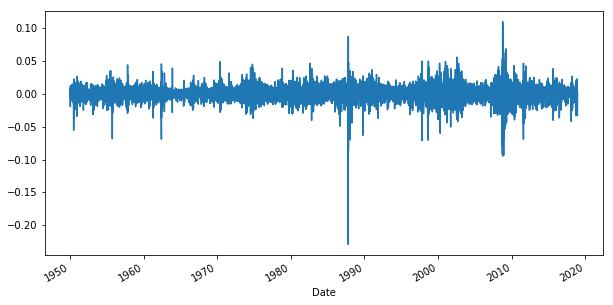

In [12]:
df_price['Return'].plot(figsize=[10, 5])

(-0.25, 0.25)

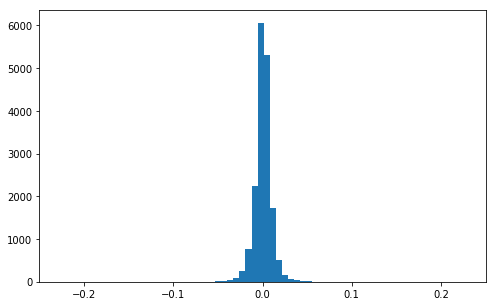

In [13]:
ax = df_price['Return'].hist(bins=50, grid=False, figsize=[8,5])
ax.set_xlim([-0.25, 0.25])

16384 16384


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


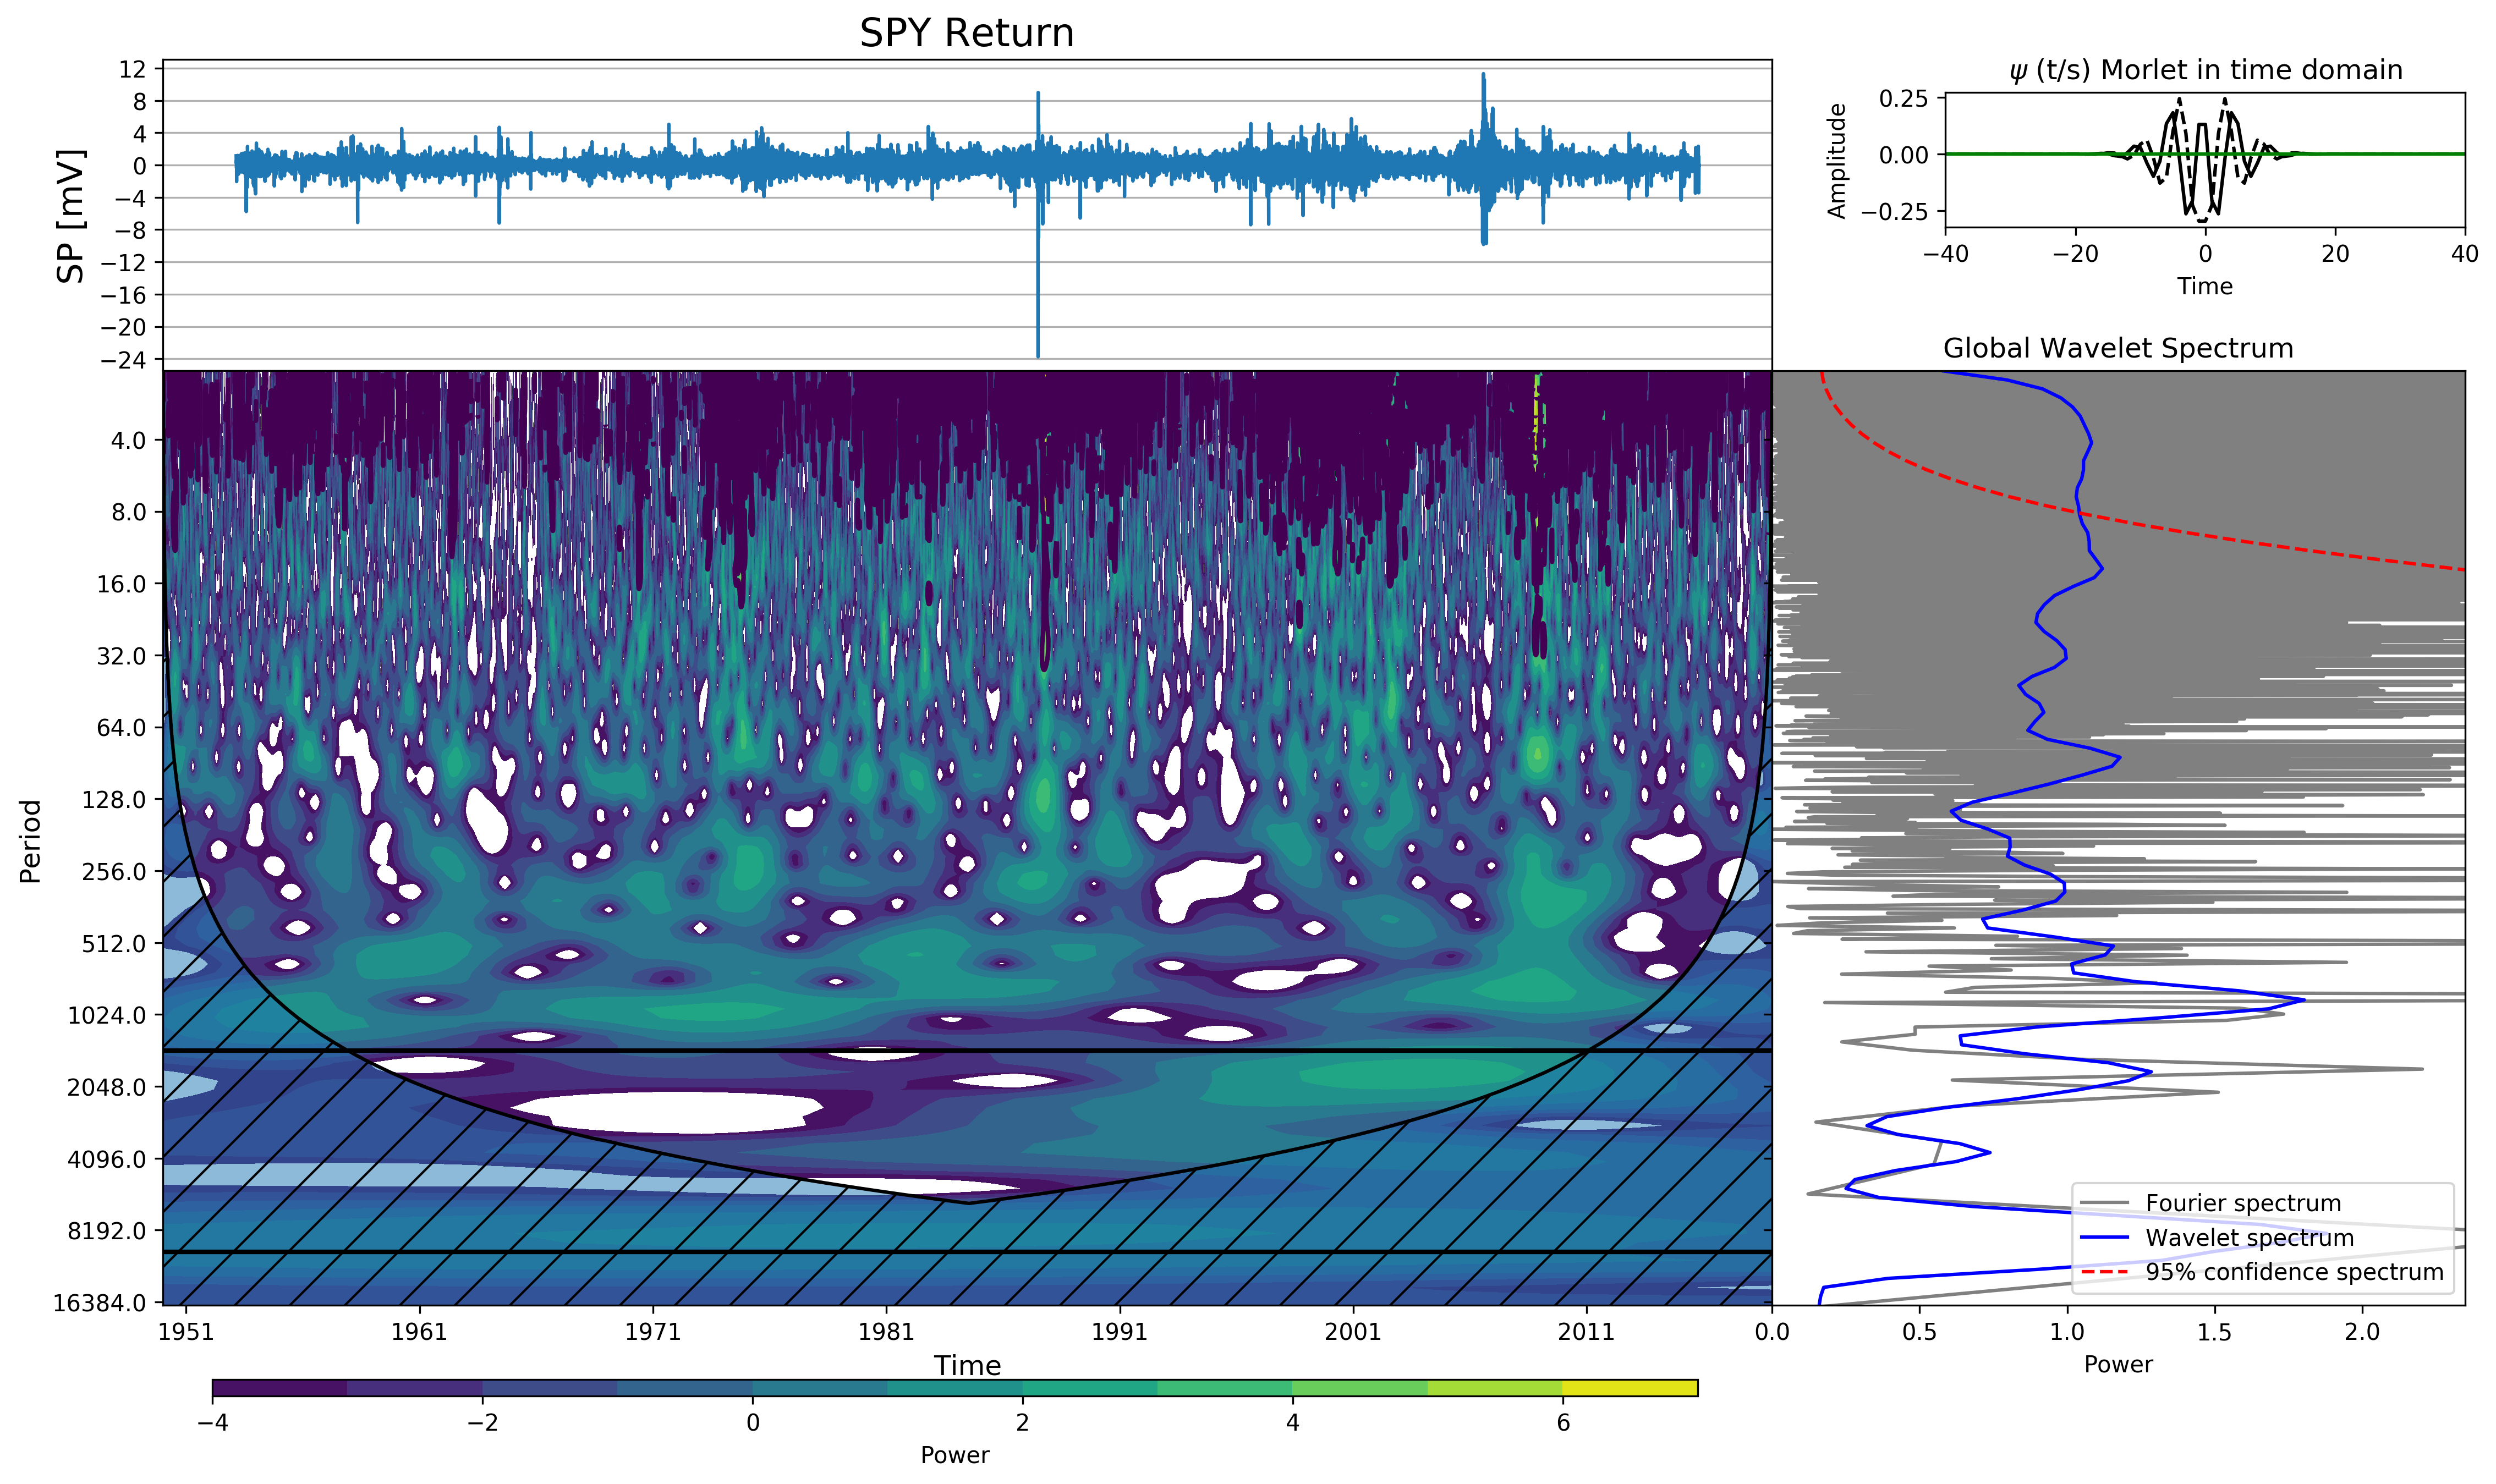

In [9]:
x = df_price['Return'].values[1:]
z = df_price.index.values[1:]

data_norm = waipy.normalize(x)
result = waipy.cwt(data_norm, 1, 1, 0.125, 2, 4/0.125, 0.72, 6, mother='Morlet',name='return')
waipy.wavelet_plot('SPY Return', z, data_norm, 0.03125, result)

In [138]:
# x = df_price['Adj Close'].values[1:]
# z = df_price.index.values[1:]

# result = waipy.cwt(x, 1, 1, 0.125, 2, 4/0.125, 0.72, 6, mother='Morlet',name='return')

16384 16384


In [139]:
# # https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2
# def reconstruct(result, i):
#     x = list(map(float, result['wave'][0]))  # real part of wavelet transform
#     x = np.array(x)
#     x /= np.sqrt(result['scale'][i])
#     return x

# x1 = reconstruct(result, 0)
# for i in range(1, 4):
#     x1 += reconstruct(result, i)

# factor = 0.125 * 1 ** (1/2)
# factor /= (0.77 * np.pi ** (1/4))

# x1 *= factor

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# mean_squared_error(x, x1)

0.00029494201253345905

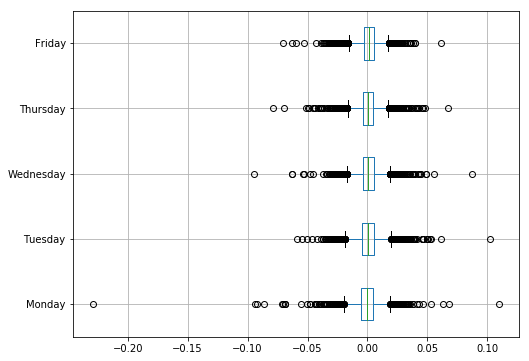

In [14]:
df_price['Week'] = df_price.index.weekday_name
df = df_price.pivot(columns='Week', values='Return')
df = df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
df.boxplot(vert=False, figsize=[8, 6])

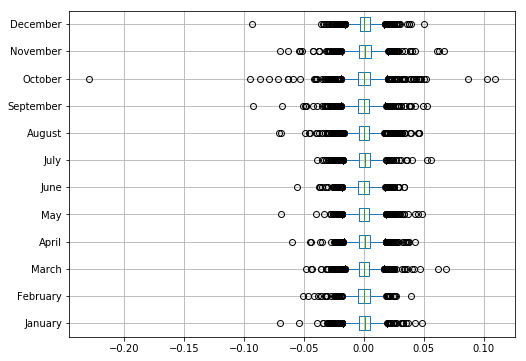

In [15]:
df_price['Month'] = df_price.index.month_name()
df = df_price.pivot(columns='Month', values='Return')
df = df[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]
df.boxplot(vert=False, figsize=[8, 6])

In [16]:
df['October'][df['October'] == df['October'].min()]

Date
1987-10-19   -0.228997
Name: October, dtype: float64

4096 4096


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


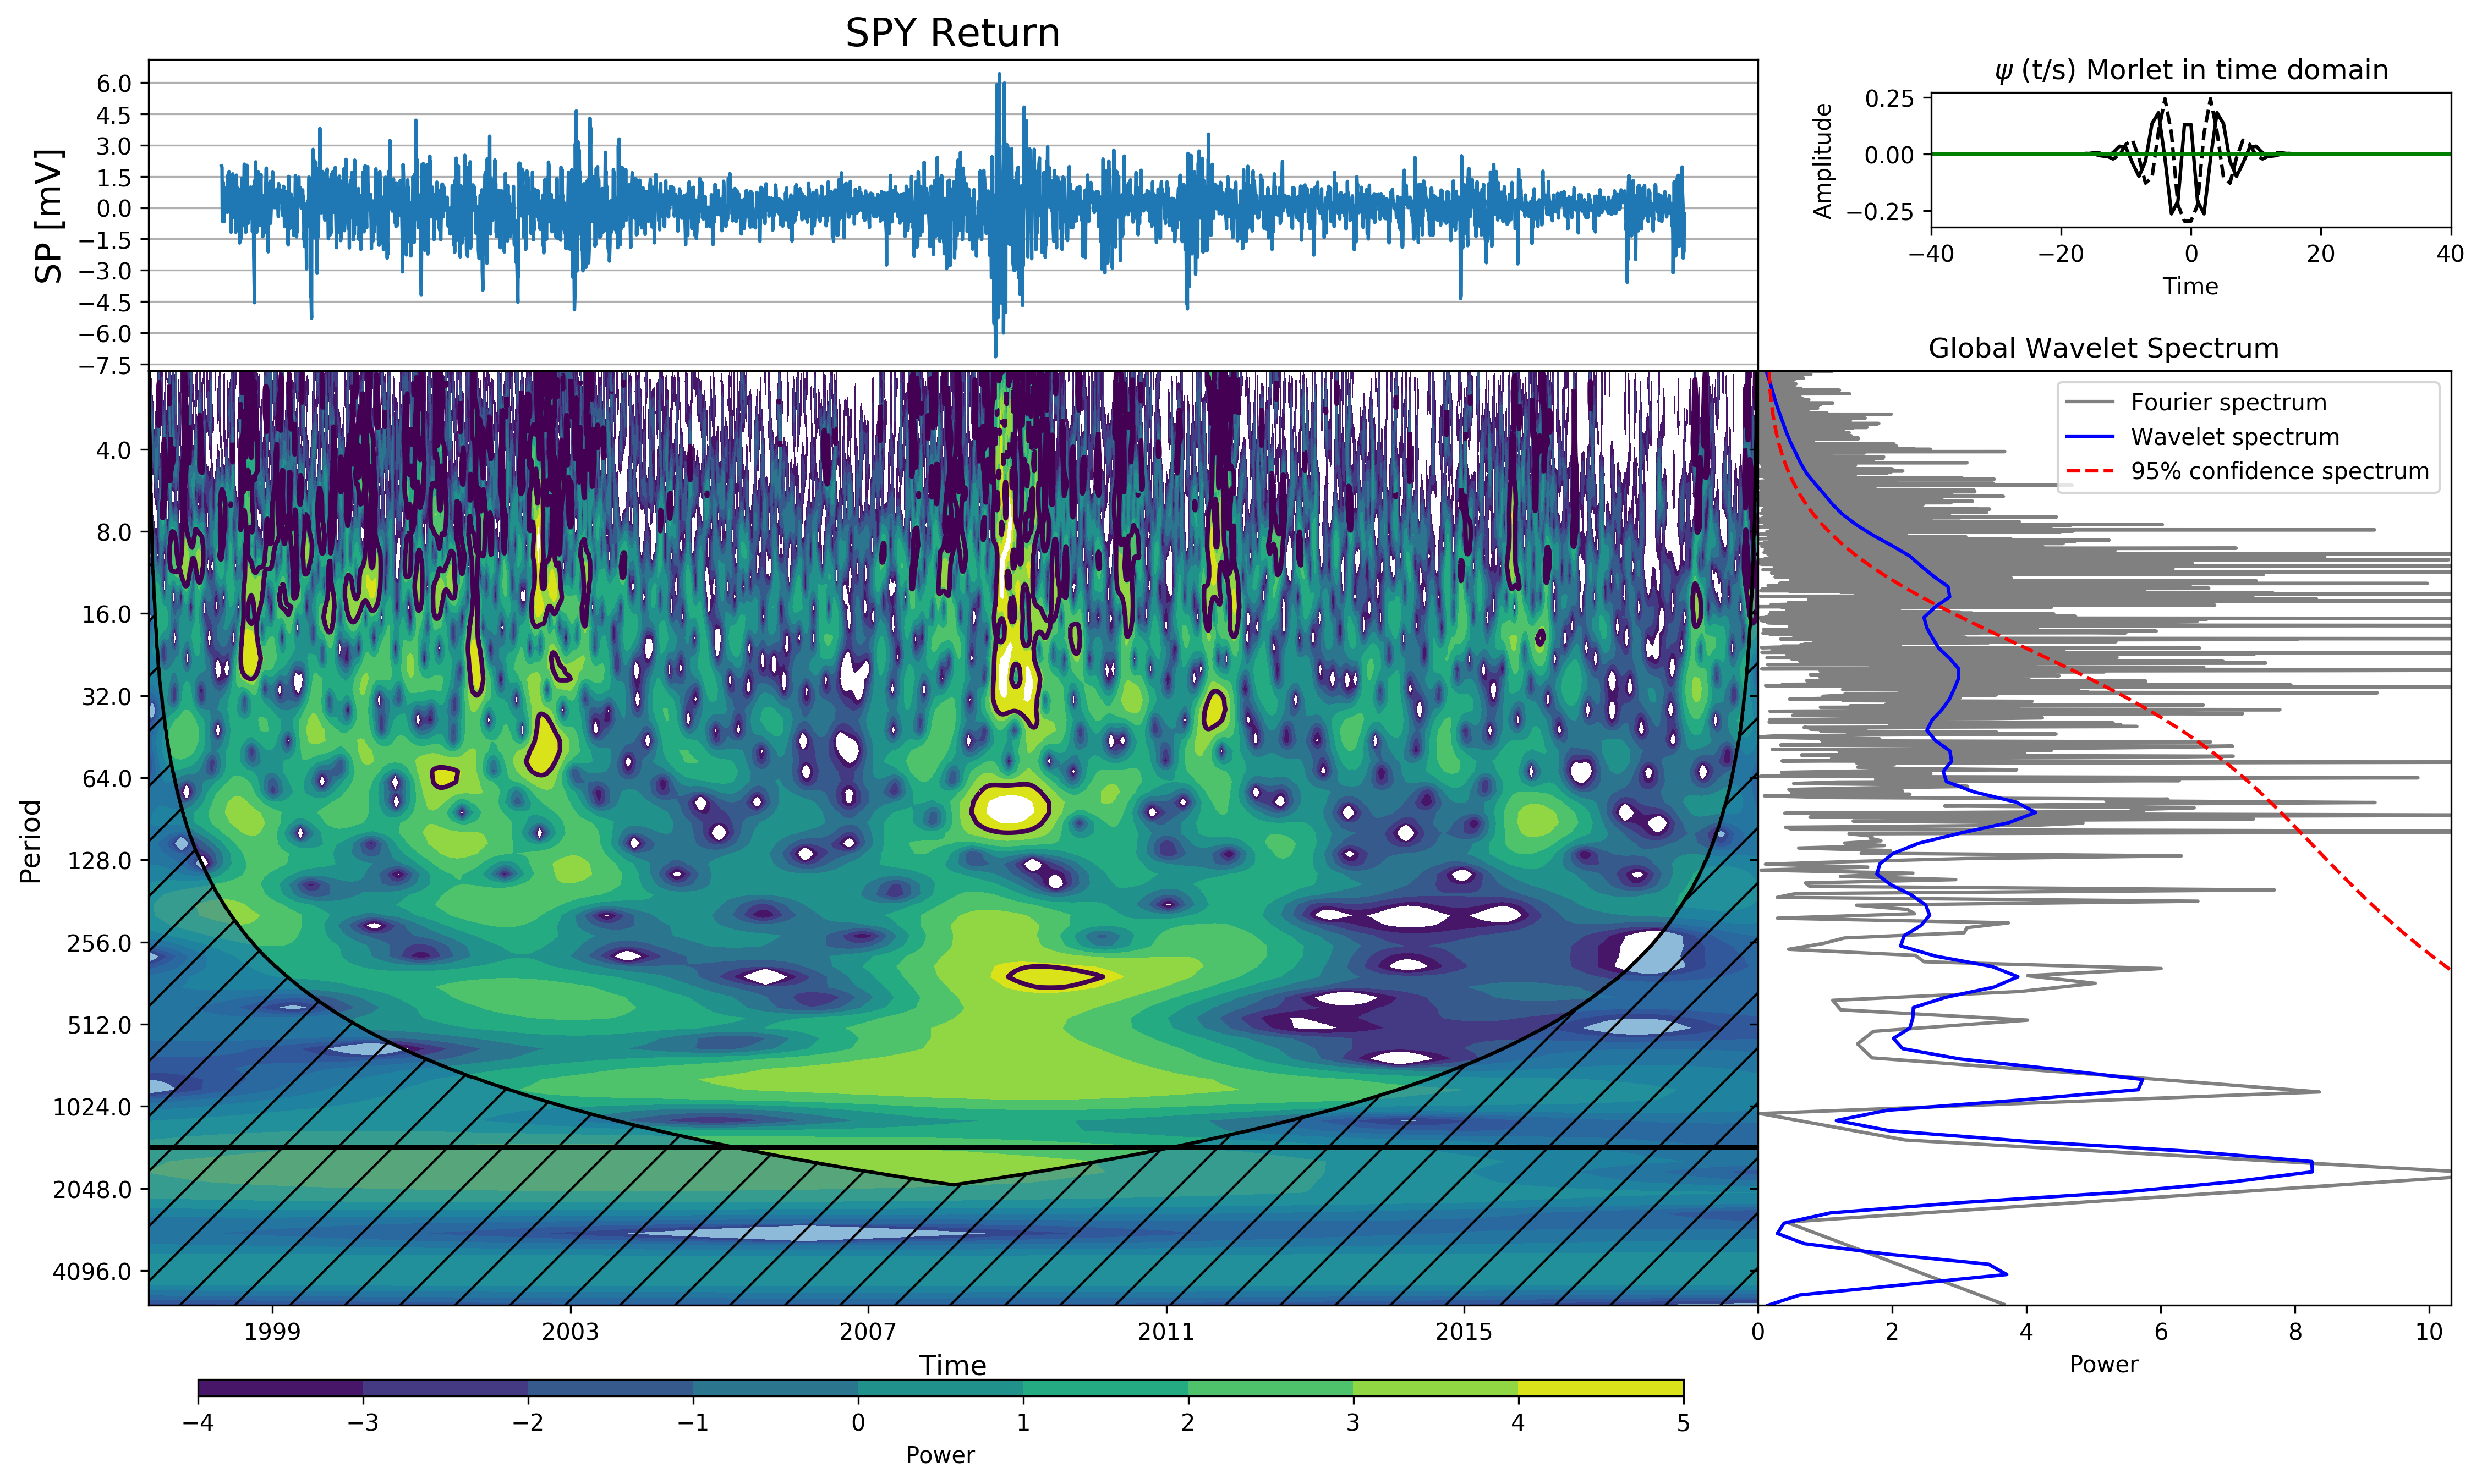

In [46]:
x = df_price['Kalman_Return'].values[1:]
z = df_price.index.values[1:]

data_norm = waipy.normalize(x)
result = waipy.cwt(data_norm, 1, 1, 0.125, 2, 4/0.125, 0.72, 6, mother='Morlet',name='return')
waipy.wavelet_plot('SPY Return', z, data_norm, 0.03125, result)

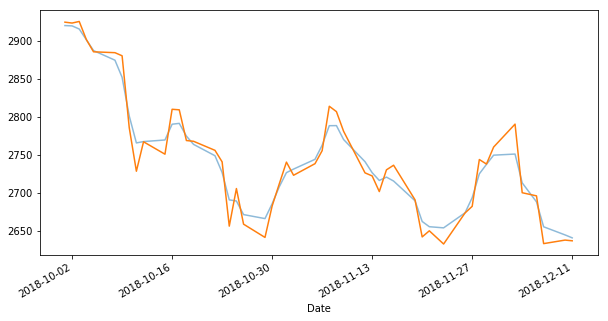

In [32]:
df_price['Kalman'].iloc[-50:].plot(figsize=[10, 5], alpha=0.5)
df_price['Adj Close'].iloc[-50:].plot()

In [7]:
df_price['Kalman_Return'] = np.log(df_price['Kalman'] / df_price['Kalman'].shift(1))
df_price['Wavelet_Return'] = np.log(df_price['Wavelet'] / df_price['Wavelet'].shift(1))
df_price['SMA_Return'] = np.log(df_price['SMA_20D'] / df_price['SMA_20D'].shift(1))

In [8]:
df_price = df_price[pd.to_datetime('1997-05-01'):]

In [9]:
df_price.to_csv('DF_SPY.csv')

In [65]:
df = df_price.copy()
df['ds'] = df.index
df['y'] = df['Adj Close']

In [32]:
fed_meetings = ['May 20, 1997', 'July 2, 1997', 'August 19, 1997', 'September 30, 1997', 'November 12, 1997', 
                'December 16, 1997', 'February 4, 1998', 'March 31, 1998', 'May 19, 1998', 'July 1, 1998', 
                'August 18, 1998', 'September 29, 1998', 'October 15, 1998', 'November 17, 1998', 'December 22, 1998', 
                'February 3, 1999', 'March 30, 1999', 'May 18, 1999', 'June 30, 1999', 'August 24, 1999', 
                'October 5, 1999', 'November 16, 1999', 'December 21, 1999', 'February 2, 2000', 'March 21, 2000', 
                'May 16, 2000', 'June 28, 2000', 'August 22, 2000', 'October 3, 2000', 'November 15, 2000', 
                'December 19, 2000', 'January 3, 2001', 'January 31, 2001', 'March 20, 2001', 'April 18, 2001', 
                'May 15, 2001', 'June 27, 2001', 'August 21, 2001', 'September 17, 2001', 'January 30, 2002', 
                'March 19, 2002', 'May 7, 2002', 'June 26, 2002', 'August 13, 2002', 'September 24, 2002', 
                'November 6, 2002', 'December 10, 2002', 'January 29, 2003', 'March 18, 2003', 'May 6, 2003', 
                'June 25, 2003', 'August 12, 2003', 'September 16, 2003', 'October 28, 2003', 'December 9, 2003', 
                'January 28, 2004', 'March 16, 2004', 'May 4, 2004', 'June 30, 2004', 'August 10, 2004', 
                'September 21, 2004', 'November 10, 2004', 'December 14, 2004', 'February 2, 2005', 'March 22, 2005', 
                'May 3, 2005', 'June 30, 2005', 'August 9, 2005', 'September 20, 2005', 'November 1, 2005', 
                'December 13, 2005', 'January 31, 2006', 'March 28, 2006', 'May 10, 2006', 'June 29, 2006', 
                'August 8, 2006', 'September 20, 2006', 'October 25, 2006', 'December 12, 2006', 'January 31, 2007', 
                'March 21, 2007', 'May 9, 2007', 'June 28, 2007', 'August 7, 2007', 'September 18, 2007', 
                'October 31, 2007', 'December 11, 2007', 'January 22, 2008', 'January 30, 2008', 'March 18, 2008', 
                'April 30, 2008', 'June 25, 2008', 'August 5, 2008', 'September 16, 2008', 'October 8, 2008', 
                'January 28, 2009', 'March 18, 2009', 'April 29, 2009', 'June 24, 2009', 'August 12, 2009', 
                'September 23, 2009', 'November 4, 2009', 'December 16, 2009', 'January 27, 2010', 'March 16, 2010', 
                'April 28, 2010', 'June 23, 2010', 'August 10, 2010', 'September 21, 2010', 'November 3, 2010', 
                'December 14, 2010', 'January 26, 2011', 'March 15, 2011', 'April 27, 2011', 'June 22, 2011', 
                'August 9, 2011', 'September 21, 2011', 'November 2, 2011', 'December 13, 2011', 'January 25, 2012', 
                'March 13, 2012', 'April 25, 2012', 'June 20, 2012', 'August 1, 2012', 'September 13, 2012', 
                'October 24, 2012', 'December 12, 2012', 'January 30, 2013', 'March 20, 2013', 'May 1, 2013', 
                'June 19, 2013', 'July 31, 2013', 'September 18, 2013', 'October 30, 2013', 'December 18, 2013', 
                'January 29, 2014', 'March 19, 2014', 'April 30, 2014', 'June 18, 2014', 'July 30, 2014', 
                'September 17, 2014', 'October 29, 2014', 'December 17, 2014', 'January 28, 2015', 'March 18, 2015', 
                'April 29, 2015', 'June 17, 2015', 'July 29, 2015', 'September 17, 2015', 'October 28, 2015', 
                'December 16, 2015', 'January 27, 2016', 'March 16, 2016', 'April 27, 2016', 'June 15, 2016', 
                'July 27, 2016', 'September 21, 2016', 'November 2, 2016', 'December 14, 2016', 'February 1, 2017', 
                'March 15, 2017', 'May 3, 2017', 'June 14, 2017', 'July 26, 2017', 'September 20, 2017', 
                'November 1, 2017', 'December 13, 2017', 'January 31, 2018', 'March 21, 2018', 'May 2, 2018', 
                'June 13, 2018', 'August 1, 2018', 'September 26, 2018', 'November 8, 2018', 'December 19, 2018', 
                'January 30, 2019', 'March 20, 2019', 'May 1, 2019', 'June 19, 2019', 'July 31, 2019', 
                'September 18, 2019', 'October 30, 2019', 'December 11, 2019', 'January 29, 2020']
fed_meetings = pd.to_datetime(fed_meetings)
df_fed = pd.DataFrame({'holiday': 'fed meeting','ds': fed_meetings,'lower_window': -1, 'upper_window': 5})

In [33]:
m = Prophet(weekly_seasonality=True, 
            yearly_seasonality=True, 
            daily_seasonality=False, holidays=df_fed)
m.add_seasonality('quarterly', period=60, fourier_order=8, mode='additive')
m.add_seasonality('5 year', period=1000, fourier_order=8, mode='additive')
m.fit(df_test[['ds', 'y']])

In [34]:
future = m.make_future_dataframe(periods=1030, freq='B')
future.tail()

,ds
5375,2018-07-19
5376,2018-07-20
5377,2018-07-23
5378,2018-07-24
5379,2018-07-25


In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5375,2018-07-19,2680.199312,739.164466,4451.951578
5376,2018-07-20,2680.598829,746.912452,4462.145425
5377,2018-07-23,2685.586512,734.558288,4450.006429
5378,2018-07-24,2686.461647,730.343833,4464.405189
5379,2018-07-25,2686.259904,769.040964,4445.239782


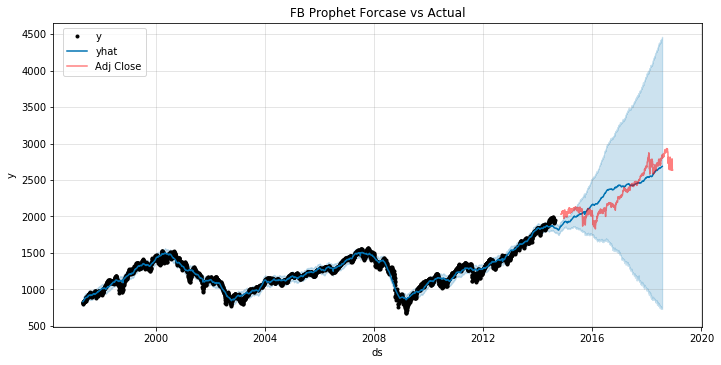

In [64]:
fig, ax = plt.subplots(figsize=[10, 5])
m.plot(forecast, ax)
ax.plot(df.iloc[-1030:]['Adj Close'], alpha=0.5, color='red')
ax.set_title('FB Prophet Forcase vs Actual')
ax.legend(bbox_to_anchor=(0.15, 1))

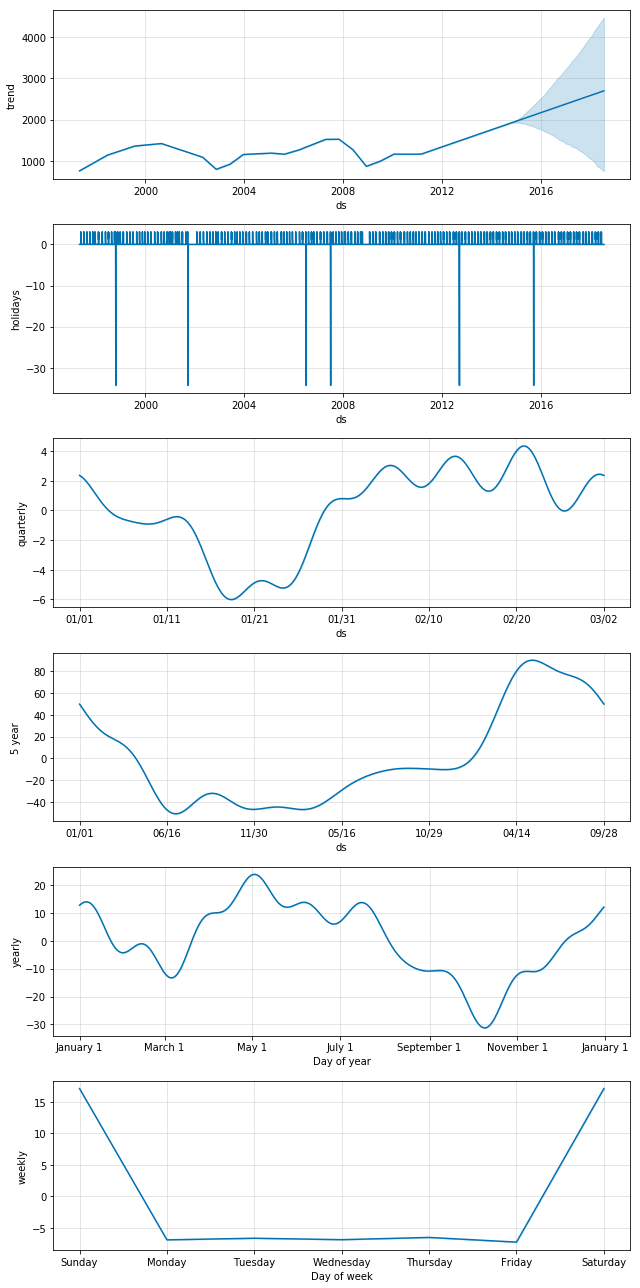

In [37]:
fig2 = m.plot_components(forecast)

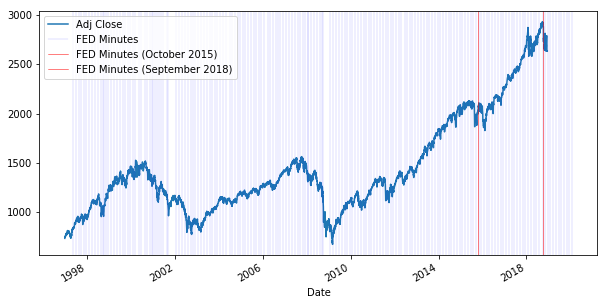

In [194]:
ax = df['Adj Close'].plot(figsize=[10, 5])
ax.axvline(x=fed_meetings[0], color='blue', linewidth=0.25, alpha=0.5, label='FED Minutes')
for fed_meeting in fed_meetings[1:]:
    ax.axvline(x=fed_meeting, color='blue', linewidth=0.25, alpha=0.5)
ax.axvline(x=pd.to_datetime('October 27, 2015'), color='red', linewidth=0.5, label='FED Minutes (October 2015)')
ax.axvline(x=pd.to_datetime('September 25, 2018'), color='red', linewidth=0.5, label='FED Minutes (September 2018)')
plt.legend()

In [95]:
input_size = 5
num_steps = 12
n_epochs = 200

cutoff = int(len(df) * 0.8)
cutoff = int(cutoff / input_size)

seq = df.index.values
seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]
X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
x_date = X[cutoff:]

y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
y_date = y[cutoff:]

In [96]:
seq = df['Return'].values
seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]

y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
y_train, y_test = y[:cutoff], y[cutoff:]
X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
x_train, x_test = X[:cutoff], X[cutoff:]

In [131]:
longshort = [100]
yhat = []
for i in range(x_date.shape[0]):
    input_dates = x_date[i].flatten()
    df0 = df.loc[:input_dates[-1]]
    m = Prophet(weekly_seasonality=True, 
                yearly_seasonality=True, 
                daily_seasonality=False, holidays=df_fed)
    m.add_seasonality('quarterly', period=60, fourier_order=8, mode='additive')
    m.add_seasonality('5 year', period=1000, fourier_order=8, mode='additive')
    m.fit(df0[['ds', 'y']])
    future = m.make_future_dataframe(periods=7, freq='B')  # 7 day in case of holiday
    forecast = m.predict(future)
    forecast_vals = forecast[forecast['ds'].isin(y_date[i])]['yhat'].values
    yhat.append(forecast_vals)
    if forecast_vals[-1] >= forecast_vals[0]:  # buy/hold
        for ret in y_test[i]:
            longshort.append(longshort[-1] * np.exp(ret))
    else:
        for ret in y_test[i]:
            longshort.append(longshort[-1] * np.exp(-ret))

Text(0.5,1,'Fbprophet Portfolio Performance')

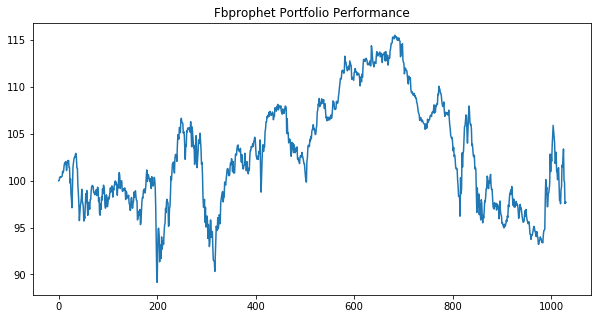

In [132]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(longshort)
ax.set_title('Fbprophet Portfolio Performance')

In [133]:
longshort = pd.Series(longshort)
returns = longshort.pct_change()

print('Total Return =', longshort.iloc[-1] / longshort.iloc[0] - 1)
print('Return Mean = ', returns.mean() * 100)
print('Return Stdev = ', returns.std() * 100)
print('Sharpe = ', returns.mean() / returns.std() * 100)

Total Return = -0.022955352975911003
Return Mean =  0.0012290893278681036
Return Stdev =  0.8351891515930998
Sharpe =  0.14716299002730704


In [147]:
# yhat = np.array(yhat)
mean_squared_error(y_test.flatten(), yhat)

7.486327826904702e-05

In [137]:
yhat = yhat.flatten()

In [140]:
yhat = pd.Series(yhat)

In [144]:
yhat = np.log(yhat / yhat.shift(1)).values

In [146]:
yhat[0] = 0

In [138]:
len(yhat)

1030

In [139]:
len(y_test.flatten())

1030

In [122]:
# portfolio_vals = df[y_date.flatten()[0]:]['Adj Close']
# portfolio_vals = portfolio_vals / portfolio_vals.iloc[0] * 100

# print('Total Return =', portfolio_vals.iloc[-1] / portfolio_vals.iloc[0] - 1)
# print('Return Mean = ', returns.mean() * 100)
# print('Return Stdev = ', returns.std() * 100)
# print('Sharpe = ', returns.mean() / returns.std() * 100)

# fig, ax = plt.subplots(figsize=[10, 5])
# ax.plot(portfolio_vals)
# ax.set_title('SPY Portfolio Performance')

Total Return = 0.2976790286537474
Return Mean =  0.0012290893278681036
Return Stdev =  0.8351891515930998
Sharpe =  0.14716299002730704
